In [176]:
from src.dataloader import *

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn


import tensorflow as tf
import keras
import keras.layers as layers

In [177]:
tf.random.set_seed(42)

# Import des données

## Terminologie: Définition des hyperparamètres du modèle

* Hyperparamètre = Paramètre qui contrôle le processus d'apprentissage de notre réseau de neurones.

* Batch Size = Hyperparamètre qui définit le nombres d'images traitées par notre algorithme avant de mettre à jour les paramètres du modèle (ses poids et ses biais). Plus le batck size est élevé, plus il faut de mémoire. En général, on utilise des batchs de taille 64, 128, 256 ou 512.

* Epoch = Hyperparamètre qui définit le nombre d'itérations effectuées sur toutes les données d'apprentissage pour entraîner notre modèle.

* Learning rate = Hyperparamètre qui contrôle la taille du pas effectué quand on se déplace vers le minimum de la fonction de perte. Si sa valeur est trop importante on risque d'osciller autour du minimum sans converger vers sa valeur et si le learning rate est trop faible on mettra trop de temps

Exemple: si j'ai 1000 individus dans l'échantillon d'apprentissage, que batch_size = 500 et epoch = 2.
* Première étape : On tire 500 individus dans l'échantillon d'apprentissage et on met à jour les paramètres de notre modèle.
* Deuxième étape : On tire les 500 derniers individus de l'échantillon d'apprentissage et on met à jour les paramètres de notre modèle. La première itération du paramètre epoch est achevée.
* Troisième étape : On tire à nouveau 500 individus dans l'échantillon d'apprentissage et on met à jour les paramètres de notre modèle (ces individus avaient déjà été tirés tirés dans l'étape un ou deux).
* Quatrième étape : On tire les 500 derniers individus de l'échantillon d'apprentissage et on met à jour les paramètres de notre modèle. La seconde itération du paramètre epoch est achevée.

Ainsi, dans notre exemple, il faut deux itérations pour réaliser un epoch.

In [178]:
label_attribution=LabelAttribution(path_image_google="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", 
                                   path_mask_google='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/mask/',
                                   path_metadata='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/metadata.csv',
                                   colonne_identifiant='identifiant',
                                   path_export_train_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps",
                                   path_image_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/img',
                                   path_mask_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/mask/',
                                   use_img_google=True,
                                   use_img_ign=False
                                    )

In [179]:
label_attribution.run()

Le LeNET5 a été conçu pour prendre en entrée des images de dimension 28*28. On passe donc les images 400 x 400 en 28 x 28. On convertit ensuite ces dernières en tenseurs. 

In [224]:
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))
transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))

In [229]:
transformed_train_dataset.__getitem__(0)[0].permute(1, 2, 0).shape

torch.Size([28, 28, 3])

In [181]:
print("Nombre d'images dans le train: {}".format(transformed_train_dataset.__len__()))
print("Nombre d'images dans le test: {}".format(transformed_test_dataset.__len__()))

Nombre d'images dans le train: 23045
Nombre d'images dans le test: 5762


In [182]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=64, shuffle=True)

In [230]:
train_dataloader

Feature batch shape: torch.Size([64, 3, 28, 28])


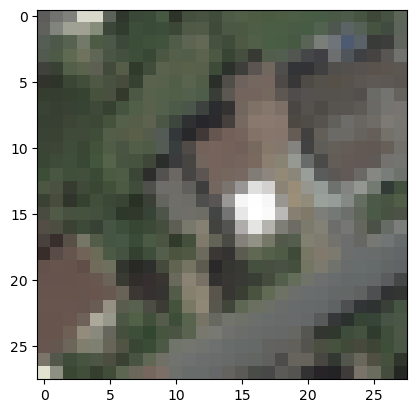

Label: 1


In [184]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[2].squeeze()
label = train_labels[2]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

On normalise aussi les images: pour chaque chaque channel d'un tenseur, on met la moyenne à 0 et la variance à 1.


output[channel] = (input[channel] - mean[channel]) / std[channel]

In [185]:
mean, std = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean))
print("Ecart-type par channel: {}".format(std))

Moyenne par channel: tensor([0.3651, 0.3608, 0.3116])
Ecart-type par channel: tensor([0.1712, 0.1494, 0.1448])


Comme on a utilisé des batches, les moyennes et écart-types calculés précédemment sont faux. On utilise, le code suivant.

In [186]:
mean_train, std_train = batch_mean_and_sd(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))

Moyenne par channel: [0.3492565155029297, 0.35663557052612305, 0.3071684241294861]
Ecart-type par channel: [0.16620320081710815, 0.14752358198165894, 0.14564624428749084]


In [187]:
mean_test, std_test = batch_mean_and_sd(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))

Moyenne par channel: [0.34999263286590576, 0.35766589641571045, 0.30810633301734924]
Ecart-type par channel: [0.16761943697929382, 0.14885348081588745, 0.14731383323669434]


On normalise les données. On ajoute aussi des rotations horizontales aléatoires. Avec probabilité 0.5, l'image est retournée.

In [188]:
normalized_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_train.tolist(),
                                                                    std= std_train.tolist()),
                                               transforms.RandomHorizontalFlip(),
                                           ]))

normalized_test_dataset  = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_test.tolist(),
                                                                    std= std_test.tolist()),
                                               transforms.RandomHorizontalFlip(),
                                           ]))

train_dataloader = DataLoader(normalized_train_dataset, batch_size=23045, shuffle=False)
test_dataloader = DataLoader(normalized_test_dataset, batch_size=5762, shuffle=False)

# Hyperparamétrisation du modèle

## 1ère approche: Grid search

https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

Pour chaque hyperparamètre: batch_size, nb_epoch et learning rate, on définit un ensemble de valeur à tester. On teste toutes les combinaisons possibles et on choisit la meilleure.

Avantages: permet de trouver les meilleurs hyperparamètres
Limites: computation lente, souffre du fléau de la dimension.

In [189]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [248]:
from keras.losses import BinaryCrossentropy
loss_function_used = BinaryCrossentropy()

def buildModel(learnRate=0.01, dropout=0.02):
    model = keras.Sequential()
    # Layer 1 Conv2D
    model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,3), padding="same"))
    # Layer 2 Pooling Layer
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Layer 3 Conv2D
    model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    # Layer 4 Pooling Layer
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=120, activation='tanh'))
    model.add(layers.Dense(units=84, activation='tanh'))
    model.add(layers.Dense(units=2, activation=None))
    model.compile(optimizer='sgd',loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy'])


    #model.compile(loss=loss_function_used, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['acc',f1_m,precision_m, recall_m])

    return model


In [195]:
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128, 256]
epochs = [10, 20, 30, 40]

grid = dict(
	learnRate=learnRate,
	dropout=dropout,
	batch_size=batchSize,
	epochs=epochs
)

In [205]:
X_train, Y_train=next(iter(train_dataloader))

In [197]:
X_test, Y_test=next(iter(test_dataloader))

In [239]:
X_train_permute=X_train.permute(0, 2, 3,1)
X_test_permute=X_test.permute(0, 2, 3,1)

In [250]:
model=buildModel()

H = model.fit(x=X_train_permute.numpy(), y=Y_train.numpy(),
	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
	batch_size=8,
	epochs=5)

Epoch 1/5
2881/2881 [==============================] - 10s 3ms/step - loss: 7.4127 - accuracy: 0.4894 - val_loss: 7.6605 - val_accuracy: 0.5476
Epoch 2/5
2881/2881 [==============================] - 8s 3ms/step - loss: 7.6157 - accuracy: 0.5587 - val_loss: 7.6161 - val_accuracy: 0.5455
Epoch 3/5
2881/2881 [==============================] - 8s 3ms/step - loss: 7.6041 - accuracy: 0.5537 - val_loss: 7.5044 - val_accuracy: 0.5621
Epoch 4/5
2881/2881 [==============================] - 8s 3ms/step - loss: 7.4144 - accuracy: 0.5513 - val_loss: 7.3154 - val_accuracy: 0.5302
Epoch 5/5
2881/2881 [==============================] - 9s 3ms/step - loss: 7.1878 - accuracy: 0.5411 - val_loss: 6.9142 - val_accuracy: 0.5524


In [252]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=buildModel, verbose=1)
#grid = GridSearchCV(estimator=model, param_grid=hyperMatrix)

scoring = {'Log loss': 'neg_log_loss', 'F1': 'f1', 'Bal Acc': 'balanced_accuracy'}

searcher = RandomizedSearchCV(estimator=model, cv=3, param_distributions=grid, scoring="accuracy")
searchResults = searcher.fit(X_train_permute.numpy(), Y_train.numpy())

Epoch 1/30
61/61 [==============================] - 2s 28ms/step - loss: 5.2984 - accuracy: 0.4602
Epoch 2/30
61/61 [==============================] - 2s 28ms/step - loss: 4.5767 - accuracy: 0.4980
Epoch 3/30
61/61 [==============================] - 2s 28ms/step - loss: 5.2884 - accuracy: 0.4647
Epoch 4/30
61/61 [==============================] - 2s 28ms/step - loss: 5.2080 - accuracy: 0.4535
Epoch 5/30
61/61 [==============================] - 2s 28ms/step - loss: 4.7391 - accuracy: 0.5814
Epoch 6/30
61/61 [==============================] - 2s 28ms/step - loss: 4.9506 - accuracy: 0.5800
Epoch 7/30
61/61 [==============================] - 2s 28ms/step - loss: 5.0245 - accuracy: 0.4920
Epoch 8/30
61/61 [==============================] - 2s 28ms/step - loss: 6.9535 - accuracy: 0.4804
Epoch 9/30
61/61 [==============================] - 2s 29ms/step - loss: 6.4864 - accuracy: 0.5219
Epoch 10/30
61/61 [==============================] - 2s 29ms/step - loss: 5.9178 - accuracy: 0.4674
Epoch 11/

KeyboardInterrupt: 

In [ ]:
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
	bestParams))